# Adversarial Attack

This notebook is under progress.

### Here, we will conduct 5 different types of attack on two simple CNNs:
#### 1. Random Noise Attack
#### 2. Projected Gradient Descent (PGD)
#### 3. Fast Gradient Method (FGSM)
#### 4. Random Fast Gradient Method (rFGSM)
#### 5. FGM L2 Attack

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
import torch.optim as optim
from torch.utils.data import random_split
import warnings
import matplotlib.pyplot as plt
import math
import numpy as np
from torchsummary import summary
import random

In [2]:
class NetA(nn.Module):
    def __init__(self,num_classes=10):
        super(NetA, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1,32,3,1,1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,3,1,1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64,128,3,1,1),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Sequential(
            nn.Linear(7*7*128, 256),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0),-1)
        out = self.classifier(out)
        return out

class NetB(nn.Module):
    def __init__(self,num_classes=10):
        super(NetB, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1,32,3,1,1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32,32,3,1,1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,3,1,1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,64,3,1,1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(7*7*64, 256),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0),-1)
        out = self.classifier(out)
        return out

In [3]:
def random_noise_attack(model, device, dat, eps):
    # Add uniform random noise in [-eps,+eps]
    x_adv = dat.clone().detach() + torch.FloatTensor(dat.shape).uniform_(-eps, eps).to(device)
    # Clip the perturbed datapoints to ensure we are in bounds [0,1]
    x_adv = torch.clamp(x_adv.clone().detach(), 0., 1.)
    return x_adv

# Compute the gradient of the loss w.r.t. the input data
def gradient_wrt_data(model,device,data,lbl):
    dat = data.clone().detach()
    dat.requires_grad = True
    out = model(dat)
    loss = F.cross_entropy(out,lbl)
    model.zero_grad()
    loss.backward()
    data_grad = dat.grad.data
    return data_grad.data.detach()


def PGD_attack(model, device, dat, lbl, eps, alpha, iters, rand_start):
    x_nat = dat.clone().detach()
    # If rand_start is True, add uniform noise to the sample within [-eps,+eps],
    # else just copy x_nat
    if rand_start:
        x_adv = random_noise_attack(model, device, x_nat, eps)
    else:
        x_adv = x_nat.clone()

    # Make sure the sample is projected into original distribution bounds [0,1]
    x_adv = torch.clamp(x_adv, 0., 1.)
    for _ in range(iters):
        # Compute gradient w.r.t. data (we give you this function, but understand it)
        data_grad = gradient_wrt_data(model, device, x_adv, lbl)
        # Perturb the image using the gradient
        x_adv = x_adv + alpha * torch.sign(data_grad)
        # Clip the perturbed datapoints to ensure we still satisfy L_infinity constraint
        x_adv = torch.clamp(x_adv, -eps+x_nat, eps+x_nat)
        # Clip the perturbed datapoints to ensure we are in bounds [0,1]
        x_adv = torch.clamp(x_adv, 0., 1.)
    return x_adv


def FGSM_attack(model, device, dat, lbl, eps):
    x_nat = dat.clone().detach()
    x_adv = torch.clamp(x_nat, 0., 1.)
    data_grad = gradient_wrt_data(model, device, x_adv, lbl)
    x_adv = x_adv + eps * torch.sign(data_grad)
    x_adv = torch.clamp(x_adv, -eps+x_nat, eps+x_nat)
    x_adv = torch.clamp(x_adv, 0., 1.)
    return x_adv


def rFGSM_attack(model, device, dat, lbl, eps):
    x_nat = dat.clone().detach()
    x_adv = random_noise_attack(model, device, x_nat, eps)
    x_adv = torch.clamp(x_adv, 0., 1.)
    data_grad = gradient_wrt_data(model, device, x_adv, lbl)
    x_adv = x_adv + eps * torch.sign(data_grad)
    x_adv = torch.clamp(x_adv, -eps+x_nat, eps+x_nat)
    x_adv = torch.clamp(x_adv, 0., 1.)
    return x_adv


def FGM_L2_attack(model, device, dat, lbl, eps):
    x_nat = dat.clone().detach()
    # Compute gradient w.r.t. data
    data_grad = gradient_wrt_data(model, device, x_nat, lbl)
    # Compute sample-wise L2 norm of gradient (L2 norm for each batch element)
    f_grad = data_grad.view(data_grad.shape[0],-1)
    l2_norm_grad = torch.linalg.norm(f_grad, dim=1).view(-1,1,1,1)
    # Perturb the data using the gradien, prevent division by 0
    l2_norm_grad = torch.clamp(l2_norm_grad, min=1e-2)
    p = eps*data_grad/l2_norm_grad
    # Add perturbation the data
    x_adv = x_nat + p
    # Clip the perturbed datapoints to ensure we are in bounds [0,1]
    x_adv = torch.clamp(x_adv, 0., 1.)
    return x_adv

In [6]:
train_loader = torch.utils.data.DataLoader(
    dsets.FashionMNIST('./data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size = 64, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dsets.FashionMNIST('./data', train=False, download=True, transform=transforms.ToTensor()),
    batch_size = 64, shuffle=False)

def test_model(model, test_loader, device):
    model.eval()
    running_correct = 0
    running_loss = 0
    running_total = 0
    with torch.no_grad():
        for batch_idx,(data,labels) in enumerate(test_loader):
            data = data.to(device); labels = labels.to(device)
            outputs = model(data)
            loss = F.cross_entropy(outputs, labels)
            _, preds = outputs.max(1)
            running_correct += preds.eq(labels).sum().item()
            running_loss += loss.item()
            running_total += labels.size(0)
    acc = running_correct/running_total
    loss = running_loss/len(test_loader)
    model.train()
    return acc,loss

def train_model(model, num_epochs, optimizer, initial_lr, lr_decay_epoch, name, device):
  for epoch in range(num_epochs):
    model.train()
    train_correct = 0.
    train_loss = 0.
    train_total = 0.
    for batch_idx,(data,labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)
        outputs = model(data)
        model.zero_grad()
        optimizer.zero_grad()
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = outputs.max(1)
        train_correct += preds.eq(labels).sum().item()
        train_loss += loss.item()
        train_total += labels.size(0)

    test_acc,test_loss = test_model(model,test_loader,device)
    if epoch % 5 == 0:
      print("Epoch: [ {} / {} ]; TrainAcc: {:.5f}; TrainLoss: {:.5f}; TestAcc: {:.5f}; TestLoss: {:.5f}".format(
          epoch, num_epochs, train_correct/train_total, train_loss/len(train_loader),
          test_acc, test_loss,
      ))
    torch.save(model.state_dict(), name)
    if epoch == lr_decay_epoch:
        for param_group in optimizer.param_groups:
            param_group['lr'] = initial_lr*0.1

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
net = NetA().to(device)

model_checkpoint = "netA_standard.pt"

num_epochs = 20
initial_lr = 0.001
lr_decay_epoch = 15

optimizer = torch.optim.Adam(net.parameters(), lr=initial_lr)

train_model(net, num_epochs, optimizer, initial_lr, lr_decay_epoch, model_checkpoint, device)

cuda
Epoch: [ 0 / 20 ]; TrainAcc: 0.84613; TrainLoss: 0.42020; TestAcc: 0.89030; TestLoss: 0.30919
Epoch: [ 5 / 20 ]; TrainAcc: 0.94318; TrainLoss: 0.15366; TestAcc: 0.91670; TestLoss: 0.24015
Epoch: [ 10 / 20 ]; TrainAcc: 0.97160; TrainLoss: 0.07552; TestAcc: 0.91710; TestLoss: 0.33582
Epoch: [ 15 / 20 ]; TrainAcc: 0.98273; TrainLoss: 0.04540; TestAcc: 0.91380; TestLoss: 0.43685


In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
net = NetB().to(device)

model_checkpoint = "netB_standard.pt"

num_epochs = 20
initial_lr = 0.001
lr_decay_epoch = 15

optimizer = torch.optim.Adam(net.parameters(), lr=initial_lr)

train_model(net, num_epochs, optimizer, initial_lr, lr_decay_epoch, model_checkpoint, device)

cuda
Epoch: [ 0 / 20 ]; TrainAcc: 0.85237; TrainLoss: 0.41196; TestAcc: 0.89240; TestLoss: 0.29970
Epoch: [ 5 / 20 ]; TrainAcc: 0.94338; TrainLoss: 0.15490; TestAcc: 0.91860; TestLoss: 0.24384
Epoch: [ 10 / 20 ]; TrainAcc: 0.96777; TrainLoss: 0.08862; TestAcc: 0.91990; TestLoss: 0.29209
Epoch: [ 15 / 20 ]; TrainAcc: 0.97967; TrainLoss: 0.05560; TestAcc: 0.91260; TestLoss: 0.37119


<ipython-input-11-a1c172dc1a5f>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("netA_standard.pt"))


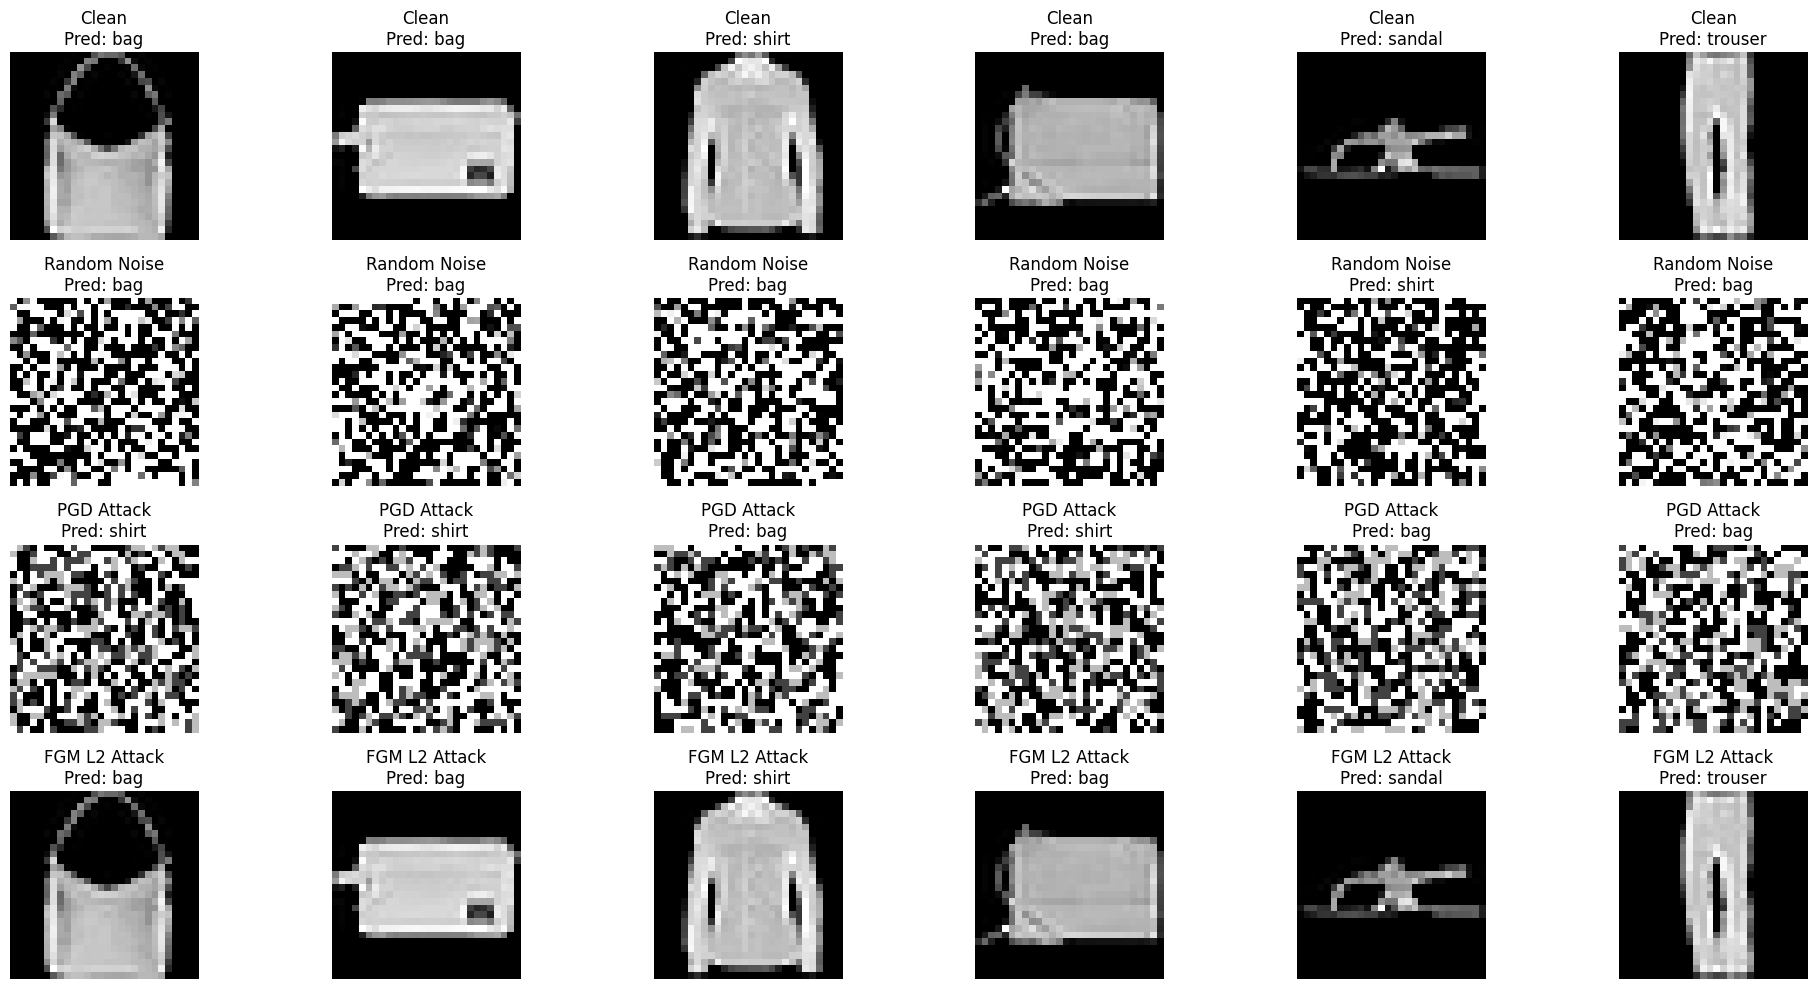

In [11]:
classes = ["t-shirt", "trouser", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "boot"]
net = NetA().to(device)
net.load_state_dict(torch.load("netA_standard.pt"))

for data, labels in test_loader:
    data = data.to(device)
    labels = labels.to(device)

    # Adversarial attack parameters
    EPS = 4
    ITS = 10
    ALP = 1.85 * (EPS / ITS)

    # Generate adversarial images with different attacks
    adv_data_random = random_noise_attack(model=net, device=device, dat=data, eps=EPS)
    adv_data_PGD = PGD_attack(model=net, device=device, dat=data, lbl=labels, eps=EPS, alpha=ALP, iters=ITS, rand_start=True)
    adv_data_FGM_L2 = FGM_L2_attack(model=net, device=device, dat=data, lbl=labels, eps=EPS)

    # Compute predictions
    with torch.no_grad():
        clean_outputs = net(data)
        _, clean_preds = clean_outputs.max(1)
        clean_preds = clean_preds.cpu().squeeze().numpy()

        adv_outputs_random = net(adv_data_random)
        _, adv_preds_random = adv_outputs_random.max(1)
        adv_preds_random = adv_preds_random.cpu().squeeze().numpy()

        adv_outputs_PGD = net(adv_data_PGD)
        _, adv_preds_PGD = adv_outputs_PGD.max(1)
        adv_preds_PGD = adv_preds_PGD.cpu().squeeze().numpy()

        adv_outputs_FGM_L2 = net(adv_data_FGM_L2)
        _, adv_preds_FGM_L2 = adv_outputs_FGM_L2.max(1)
        adv_preds_FGM_L2 = adv_preds_FGM_L2.cpu().squeeze().numpy()

    # Plot examples of clean and adversarial images
    inds = random.sample(list(range(data.size(0))), 6)
    plt.figure(figsize=(20, 10))

    for i in range(6):
        # Clean images
        plt.subplot(4, 6, i + 1)
        plt.imshow(data[inds[i], 0].cpu().numpy(), cmap='gray')
        plt.axis("off")
        plt.title(f"Clean\nPred: {classes[clean_preds[inds[i]]]}")

        # Random noise attack images
        plt.subplot(4, 6, 6 + i + 1)
        plt.imshow(adv_data_random[inds[i], 0].cpu().numpy(), cmap='gray')
        plt.axis("off")
        plt.title(f"Random Noise\nPred: {classes[adv_preds_random[inds[i]]]}")

        # PGD attack images
        plt.subplot(4, 6, 12 + i + 1)
        plt.imshow(adv_data_PGD[inds[i], 0].cpu().numpy(), cmap='gray')
        plt.axis("off")
        plt.title(f"PGD Attack\nPred: {classes[adv_preds_PGD[inds[i]]]}")

        # FGM L2 attack images
        plt.subplot(4, 6, 18 + i + 1)
        plt.imshow(adv_data_FGM_L2[inds[i], 0].cpu().numpy(), cmap='gray')
        plt.axis("off")
        plt.title(f"FGM L2 Attack\nPred: {classes[adv_preds_FGM_L2[inds[i]]]}")

    plt.tight_layout()
    plt.show()
    break

In [14]:
def test_attack(eps, iter, attack_type):
## Load pretrained models
    whitebox = NetA()
    blackbox = NetB()

    whitebox.load_state_dict(torch.load('netA_standard.pt'))
    blackbox.load_state_dict(torch.load('netB_standard.pt'))

    whitebox = whitebox.to(device); blackbox = blackbox.to(device)
    whitebox.eval(); blackbox.eval()

    ATK_EPS = eps
    ATK_ITERS = iter
    ATK_ALPHA = 1.85*(ATK_EPS/ATK_ITERS)

    whitebox_correct = 0.
    blackbox_correct = 0.
    running_total = 0.
    for batch_idx,(data,labels) in enumerate(test_loader):
        data = data.to(device)
        labels = labels.to(device)

        if attack_type == "random_noise_attack":
            adv_data = random_noise_attack(model=net, device=device, dat=data, eps=ATK_EPS)
        elif attack_type == "PGD":
            adv_data = PGD_attack(model=net, device=device, dat=data, lbl=labels, eps=ATK_EPS, alpha=ATK_ALPHA, iters=ATK_ITERS, rand_start=True)
        elif attack_type == "FGM_L2":
            adv_data = FGM_L2_attack(model=net, device=device, dat=data, lbl=labels, eps=ATK_EPS)
        elif attack_type == "rFGSM":
            adv_data = rFGSM_attack(model=net, device=device, dat=data, lbl=labels, eps=ATK_EPS)
        else:
            adv_data = FGSM_attack(model=net, device=device, dat=data, lbl=labels, eps=ATK_EPS)
        # Sanity checking if adversarial example is "legal"
        assert(torch.max(torch.abs(adv_data-data)) <= (ATK_EPS + 1e-5) )
        assert(adv_data.max() == 1.)
        assert(adv_data.min() == 0.)

        # Compute accuracy on perturbed data
        with torch.no_grad():
            whitebox_outputs = whitebox(adv_data)
            _,whitebox_preds = whitebox_outputs.max(1)
            whitebox_correct += whitebox_preds.eq(labels).sum().item()

            blackbox_outputs = blackbox(adv_data)
            _,blackbox_preds = blackbox_outputs.max(1)
            blackbox_correct += blackbox_preds.eq(labels).sum().item()
            running_total += labels.size(0)

    whitebox_acc = whitebox_correct/running_total
    blackbox_acc = blackbox_correct/running_total

    return whitebox_acc, blackbox_acc

<ipython-input-14-deb1aca2cf7c>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  whitebox.load_state_dict(torch.load('netA_standard.pt'))
<ipython-input-14-deb1aca2cf7c>:7: 

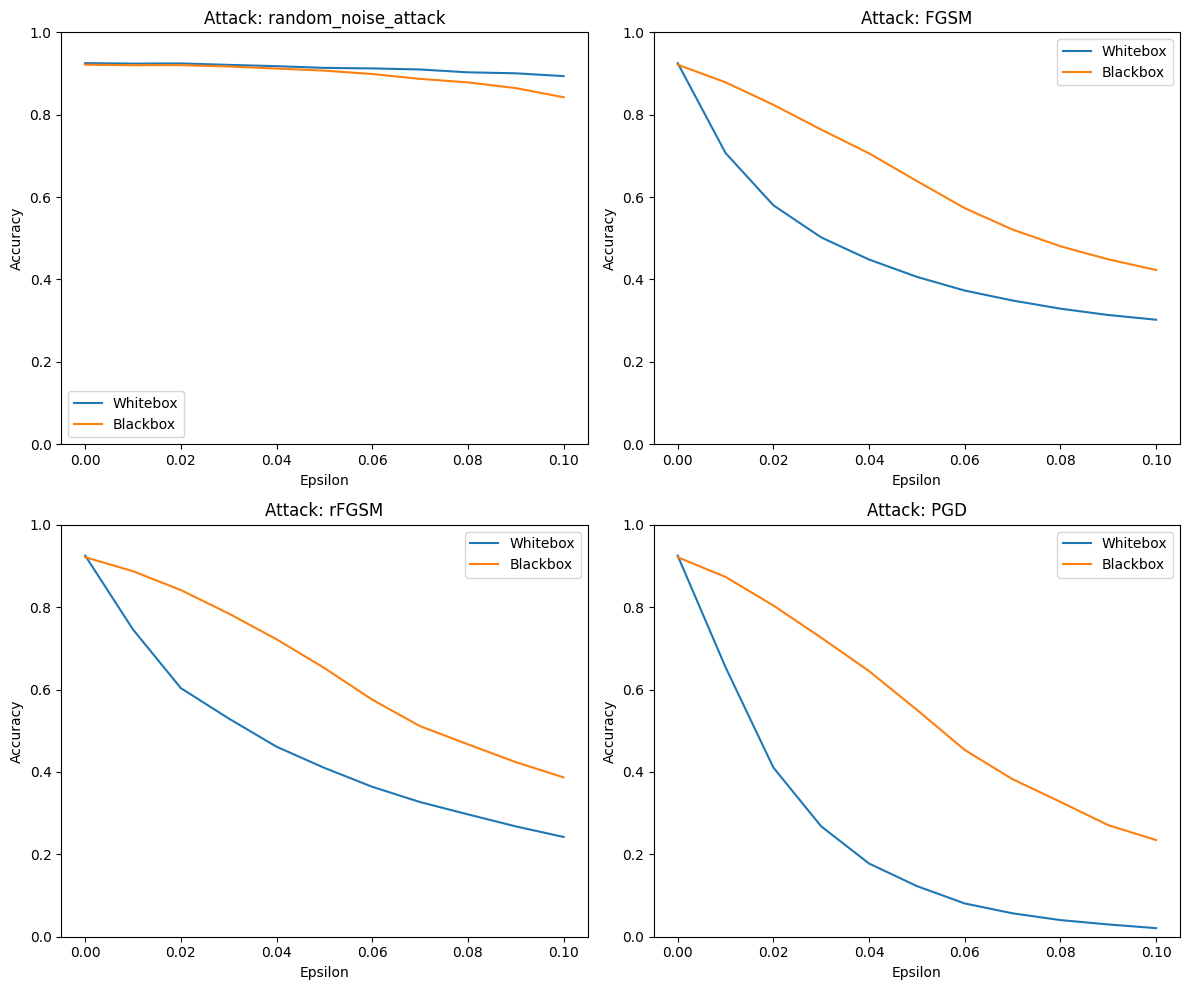

In [15]:
attack_list = ["random_noise_attack", "FGSM", "rFGSM", "PGD"]
eps_list = np.linspace(0.0, 0.1, 11)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, attack in enumerate(attack_list):
    whitebox_accs = []
    blackbox_accs = []

    for e in eps_list:
        whitebox_acc, blackbox_acc = test_attack(e, 10, attack)
        whitebox_accs.append(whitebox_acc)
        blackbox_accs.append(blackbox_acc)

    axes[i].plot(eps_list, whitebox_accs, label="Whitebox")
    axes[i].plot(eps_list, blackbox_accs, label="Blackbox")
    axes[i].set_title(f"Attack: {attack}")
    axes[i].set_xlabel("Epsilon")
    axes[i].set_ylabel("Accuracy")
    axes[i].legend()
    axes[i].set_ylim(0, 1)

plt.tight_layout()
plt.show()